In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# import numpy as np
import seaborn as sns
sns.set_theme(style="darkgrid")

In [2]:
fake_job_postings = pd.read_csv('fake_job_postings.csv')

In [3]:
fake_job_postings.describe()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
fake_job_postings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [5]:
fake_job_postings.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [6]:
from IPython.display import display, HTML
import sqlite3
from sqlite3 import Error
import csv

# master_table = pd.DataFrame(columns = ['JobType','LocationID','IndustryID','EducationID','ExperienceID','EmploymentID','Company_Profile','Company_Description','Requirement','Benefits','Telecommunication','Logo','Questions','Fraudulent'])


def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn


def create_table(conn, create_table_sql, drop_table_name=None):
    
    if drop_table_name:
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)
    
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows


In [7]:
normalized_database_filename = 'normalized.db'
conn = create_connection(normalized_database_filename, delete_db=True)

In [8]:
def create_us_table(data_filename, normalized_database_filename): 
    
    location = []
    with open('fake_job_postings.csv', 'r') as file:
        next(file)
        readline=csv.reader(file)
        for line in readline:
            data=line[2].split(',')
            if (len(data)==3) and data[0] == 'US' and data[1]!=' ' and data[2]!=' ':
                if (data[0].strip(),data[1].strip(),data[2].strip()) not in location:
                    location.append((data[0].strip(),data[1].strip(),data[2].strip(),))
                
    create_table_sql = """CREATE TABLE IF NOT EXISTS [Location] (
    [LocationID] INTEGER NOT NULL PRIMARY KEY,
    [Country] TEXT NOT NULL,
    [State] TEXT NOT NULL,
    [City] TEXT NOT NULL
    );
    """
    create_table(conn, create_table_sql,'Location')
    
    sql = ''' INSERT INTO Location (Country,State,City)
              VALUES(?,?,?) '''
    cur = conn.cursor()
    cur.executemany(sql, location)
    conn.commit()
    sql_statement = "SELECT * FROM Location"
    cs = pd.read_sql_query(sql_statement, conn)
    us_table = pd.DataFrame(cs,columns = ['LocationID','Country','State','City'])
    return us_table
    
us_table=create_us_table('fake_job_postings.csv','normalized.db')
us_table

,LocationID,Country,State,City
0,1,US,NY,New York
1,2,US,IA,Wever
2,3,US,DC,Washington
3,4,US,FL,Fort Worth
4,5,US,CA,San Francisco
...,...,...,...,...
1563,1564,US,LA,Slidell
1564,1565,US,CA,Silicon Valley/San Jose - Santa Clara
1565,1566,US,MO,Independence
1566,1567,US,NJ,Berkeley Heights


In [9]:
def create_location_to_locationid_dictionary(normalized_database_filename):
    
    
    cur = conn.cursor()
    sql_statement= "select * from Location;"
    cur.execute(sql_statement)
    locations=cur.fetchall()
    locationdata={}

    for location in locations:
        locationdata[location[1],location[2],location[3]]=location[0]
    return locationdata
location_dict=create_location_to_locationid_dictionary('normalized.db')
location_dict

{('US', 'NY', 'New York'): 1,
 ('US', 'IA', 'Wever'): 2,
 ('US', 'DC', 'Washington'): 3,
 ('US', 'FL', 'Fort Worth'): 4,
 ('US', 'CA', 'San Francisco'): 5,
 ('US', 'FL', 'Pensacola'): 6,
 ('US', 'AZ', 'Phoenix'): 7,
 ('US', 'NJ', 'Jersey City'): 8,
 ('US', 'CT', 'Stamford'): 9,
 ('US', 'FL', 'Orlando'): 10,
 ('US', 'PA', 'USA Northeast'): 11,
 ('US', 'TX', 'Austin'): 12,
 ('US', 'CA', 'Carlsbad'): 13,
 ('US', 'MO', 'St. Louis'): 14,
 ('US', 'MA', 'Waltham'): 15,
 ('US', 'WA', 'Everett'): 16,
 ('US', 'CA', 'San Ramon'): 17,
 ('US', 'NY', 'Saint Bonaventure'): 18,
 ('US', 'NY', 'Yonkers'): 19,
 ('US', 'TX', 'HOUSTON'): 20,
 ('US', 'IL', 'Chicago'): 21,
 ('US', 'PA', 'Kutztown'): 22,
 ('US', 'CA', 'Sacramento'): 23,
 ('US', 'MD', 'Columbia'): 24,
 ('US', 'OK', 'Tulsa'): 25,
 ('US', 'NE', 'Omaha'): 26,
 ('US', 'TN', 'Brentwood'): 27,
 ('US', 'OH', 'Kent'): 28,
 ('US', 'NH', 'Dover'): 29,
 ('US', 'NV', 'Carson City'): 30,
 ('US', 'NY', 'New York City'): 31,
 ('US', 'MN', 'St. Cloud'): 32,
 

In [10]:
def create_industry_table(data_filename, normalized_database_filename): 
    
    industry = []
    with open('fake_job_postings.csv', 'r') as file:
        next(file)
        readline=csv.reader(file)
        for line in readline:
            data=line[15].split(',')
            for ele in data:
                if ele!='' and ele.strip() not in industry:
                    industry.append(ele.strip())
#             print(industry)
          
    create_table_sql = """CREATE TABLE IF NOT EXISTS [Industry] (
    [IndustryID] INTEGER NOT NULL PRIMARY KEY,
    [Industry] TEXT NOT NULL
    );
    """
    create_table(conn, create_table_sql,'Industry')
    
    sql = ''' INSERT INTO Industry (IndustryID,Industry)
              VALUES(?,?) '''
    cur = conn.cursor()
    cur.executemany(sql, zip(range(1,len(industry)+1),industry))
    sql_statement = "SELECT * FROM Industry"
    ept = pd.read_sql_query(sql_statement, conn)
    industrytype_table = pd.DataFrame(ept,columns = ['IndustryID','Industry'])
    conn.commit()
    return(industrytype_table)
    
industrytype_table=create_industry_table('fake_job_postings.csv','normalized.db')
industrytype_table

,IndustryID,Industry
0,1,Marketing and Advertising
1,2,Computer Software
2,3,Hospital & Health Care
3,4,Online Media
4,5,Information Technology and Services
...,...,...
126,127,Plastics
127,128,Furniture
128,129,Shipbuilding
129,130,Alternative Dispute Resolution


In [11]:
def create_industry_to_industryid_dictionary(normalized_database_filename):
    
    
    cur = conn.cursor()
    sql_statement= "select * from Industry;"
    cur.execute(sql_statement)
    industries=cur.fetchall()
    industrydata={}

    for industry in industries:
        industrydata[industry[1]]=industry[0]
    return industrydata
industry_dict=create_industry_to_industryid_dictionary('normalized.db')
industry_dict

{'Marketing and Advertising': 1,
 'Computer Software': 2,
 'Hospital & Health Care': 3,
 'Online Media': 4,
 'Information Technology and Services': 5,
 'Financial Services': 6,
 'Management Consulting': 7,
 'Events Services': 8,
 'Internet': 9,
 'Facilities Services': 10,
 'Consumer Electronics': 11,
 'Telecommunications': 12,
 'Consumer Services': 13,
 'Construction': 14,
 'Oil & Energy': 15,
 'Education Management': 16,
 'Building Materials': 17,
 'Banking': 18,
 'Food & Beverages': 19,
 'Food Production': 20,
 'Health Wellness and Fitness': 21,
 'Insurance': 22,
 'E-Learning': 23,
 'Cosmetics': 24,
 'Staffing and Recruiting': 25,
 'Venture Capital & Private Equity': 26,
 'Leisure Travel & Tourism': 27,
 'Human Resources': 28,
 'Pharmaceuticals': 29,
 'Farming': 30,
 'Legal Services': 31,
 'Luxury Goods & Jewelry': 32,
 'Machinery': 33,
 'Real Estate': 34,
 'Mechanical or Industrial Engineering': 35,
 'Public Relations and Communications': 36,
 'Consumer Goods': 37,
 'Medical Practic

In [12]:
def create_education_table(data_filename, normalized_database_filename): 
    
    education = []
    with open('fake_job_postings.csv', 'r') as file:
        next(file)
        readline=csv.reader(file)
        for line in readline:
            data=line[14].split(',')
            for ele in data:
                if ele!='' and ele.strip() not in education:
                    education.append(ele.strip())
          
    create_table_sql = """CREATE TABLE IF NOT EXISTS [Education] (
    [EducationID] INTEGER NOT NULL PRIMARY KEY,
    [Education] TEXT NOT NULL
    );
    """
    create_table(conn, create_table_sql,'Education')
    
    sql = ''' INSERT INTO Education (EducationID,Education)
              VALUES(?,?) '''
    cur = conn.cursor()
    cur.executemany(sql, zip(range(1,len(education)+1),education))
    sql_statement = "SELECT * FROM Education"
    ept = pd.read_sql_query(sql_statement, conn)
    educationtype_table = pd.DataFrame(ept,columns = ['EducationID','Education'])
    conn.commit()
    return(educationtype_table)
    
educationtype_table=create_education_table('fake_job_postings.csv','normalized.db')
educationtype_table

,EducationID,Education
0,1,Bachelor's Degree
1,2,Master's Degree
2,3,High School or equivalent
3,4,Unspecified
4,5,Some College Coursework Completed
5,6,Vocational
6,7,Certification
7,8,Associate Degree
8,9,Professional
9,10,Doctorate


In [13]:
def create_education_to_educationid_dictionary(normalized_database_filename):
    
    
    cur = conn.cursor()
    sql_statement= "select * from Education;"
    cur.execute(sql_statement)
    education=cur.fetchall()
    educationdata={}

    for edu in education:
        educationdata[edu[1]]=edu[0]
    return educationdata
education_dict=create_education_to_educationid_dictionary('normalized.db')
education_dict

{"Bachelor's Degree": 1,
 "Master's Degree": 2,
 'High School or equivalent': 3,
 'Unspecified': 4,
 'Some College Coursework Completed': 5,
 'Vocational': 6,
 'Certification': 7,
 'Associate Degree': 8,
 'Professional': 9,
 'Doctorate': 10,
 'Some High School Coursework': 11,
 'Vocational - Degree': 12,
 'Vocational - HS Diploma': 13}

In [14]:
def create_experience_table(data_filename, normalized_database_filename): 
    
    experience = []
    with open('fake_job_postings.csv', 'r') as file:
        next(file)
        readline=csv.reader(file)
        for line in readline:
            data=line[13].split(',')
            for ele in data:
                if ele!='' and ele not in experience:
                    experience.append(ele)
          
    create_table_sql = """CREATE TABLE IF NOT EXISTS [Experience] (
    [ExperienceID] INTEGER NOT NULL PRIMARY KEY,
    [Experience] TEXT NOT NULL
    );
    """
    create_table(conn, create_table_sql,'Experience')
    
    sql = ''' INSERT INTO Experience (ExperienceID,Experience)
              VALUES(?,?) '''
    cur = conn.cursor()
    cur.executemany(sql, zip(range(1,len(experience)+1),experience))
    conn.commit()
    sql_statement = "SELECT * FROM Experience"
    ept = pd.read_sql_query(sql_statement, conn)
    experiencetype_table = pd.DataFrame(ept,columns = ['ExperienceID','Experience'])
    conn.commit()
    return(experiencetype_table)
    
experiencetype_table=create_experience_table('fake_job_postings.csv','normalized.db')
experiencetype_table

,ExperienceID,Experience
0,1,Internship
1,2,Not Applicable
2,3,Mid-Senior level
3,4,Associate
4,5,Entry level
5,6,Executive
6,7,Director


In [15]:
def create_experience_to_experienceid_dictionary(normalized_database_filename):
    
    
    cur = conn.cursor()
    sql_statement= "select * from Experience;"
    cur.execute(sql_statement)
    experience=cur.fetchall()
    experiencedata={}

    for exp in experience:
        experiencedata[exp[1]]=exp[0]
    return experiencedata
experience_dict=create_experience_to_experienceid_dictionary('normalized.db')
experience_dict

{'Internship': 1,
 'Not Applicable': 2,
 'Mid-Senior level': 3,
 'Associate': 4,
 'Entry level': 5,
 'Executive': 6,
 'Director': 7}

In [16]:
def create_employmenttype_table(data_filename, normalized_database_filename): 
    
    employment = []
    with open('fake_job_postings.csv', 'r') as file:
        next(file)
        readline=csv.reader(file)
        for line in readline:
            data=line[12].split(',')
            for ele in data:
                if ele!='' and ele not in employment:
                    employment.append(ele)
          
    create_table_sql = """CREATE TABLE IF NOT EXISTS [Employment] (
    [EmploymentID] INTEGER NOT NULL PRIMARY KEY,
    [Employment] TEXT NOT NULL
    );
    """
    create_table(conn, create_table_sql,'Employment')
    
    sql = ''' INSERT INTO Employment (EmploymentID,Employment)
              VALUES(?,?) '''
    cur = conn.cursor()
    cur.executemany(sql, zip(range(1,len(employment)+1),employment))
    sql_statement = "SELECT * FROM Employment"
    ept = pd.read_sql_query(sql_statement, conn)
    employmenttype_table = pd.DataFrame(ept,columns = ['EmploymentID','Employment'])
    conn.commit()
    return(employmenttype_table)
    
employmenttype_table=create_employmenttype_table('fake_job_postings.csv','normalized.db')
employmenttype_table

,EmploymentID,Employment
0,1,Other
1,2,Full-time
2,3,Part-time
3,4,Contract
4,5,Temporary


In [17]:
def create_employment_to_employmentid_dictionary(normalized_database_filename):
    
    
    cur = conn.cursor()
    sql_statement= "select * from Employment;"
    cur.execute(sql_statement)
    employment=cur.fetchall()
    employmentdata={}

    for emp in employment:
        employmentdata[emp[1]]=emp[0]
    return employmentdata
employment_dict=create_employment_to_employmentid_dictionary('normalized.db')
employment_dict

{'Other': 1, 'Full-time': 2, 'Part-time': 3, 'Contract': 4, 'Temporary': 5}

In [18]:
def create_master_table(data_filename, normalized_database_filename): 
    
    master = []
    location=[]
    industry=[]
    education=[]
    experience=[]
    employment=[]
    with open('fake_job_postings.csv', 'r') as file:
        next(file)
        readline=csv.reader(file)
        for line in readline:
            data=line[2].split(',')
            if (len(data)==3) and data[0] == 'US' and data[1]!=' ' and data[2]!=' ':
                if (data[0].strip(),data[1].strip(),data[2].strip()) not in location:
                    location=data[0].strip(),data[1].strip(),data[2].strip()
            data2=line[15].strip()
            industry=data2
            if industry == '':
                continue
            data3=line[14].strip()
            education=data3
            if education=='':
                continue
            data4=line[13].strip()
            experience=data4
            if experience=='':
                continue
            data5=line[12].strip()
            employment=data5
            if employment=='':
                continue

            datalist=(line[1],location_dict[location],industry_dict[industry],education_dict[education],experience_dict[experience],employment_dict[employment],line[5],line[6],line[7],line[8],line[9],line[10],line[11],line[17])
            master.append(datalist)
            

    create_table_sql = """CREATE TABLE IF NOT EXISTS [FakeJobsData] (
    [JobID] INTEGER NOT NULL PRIMARY KEY,
    [JobType] TEXT NOT NULL,
    [LocationID] INTEGER NOT NULL,
    [IndustryID] INTEGER NOT NULL,
    [EducationID] INTEGER NOT NULL,
    [ExperienceID] INTEGER NOT NULL,
    [EmploymentID] INTEGER NOT NULL,
    [Company_Profile] TEXT NOT NULL,
    [Company_Description] TEXT NOT NULL,
    [Requirement] TEXT NOT NULL,
    [Benefits] TEXT NOT NULL,
    [Telecommunication] INTEGER NOT NULL,
    [Logo] INTEGER NOT NULL,
    [Questions] INTEGER NOT NULL,
    [Fraudulent] INTEGER NOT NULL,
    FOREIGN KEY(LocationID) REFERENCES Location(LocationID),
    FOREIGN KEY (IndustryID) REFERENCES Industry(IndustryID),
    FOREIGN KEY (EducationID) REFERENCES Education(EducationID),
    FOREIGN KEY (ExperienceID) REFERENCES Experience(ExperienceID),
    FOREIGN KEY (EmploymentID) REFERENCES Employment(EmploymentID)
    );
    """
    create_table(conn, create_table_sql,'FakeJobsData')
    
    sql = ''' INSERT INTO FakeJobsData (JobType,LocationID,IndustryID,EducationID,ExperienceID,EmploymentID,Company_Profile,Company_Description,Requirement,Benefits,Telecommunication,Logo,Questions,Fraudulent)
              VALUES(?,?,?,?,?,?,?,?,?,?,?,?,?,?) '''
    cur = conn.cursor()
    cur.executemany(sql,master)
    sql_query = pd.read_sql_query ('SELECT * FROM FakeJobsData', conn)
    master_table = pd.DataFrame(sql_query,columns = ['JobID','JobType','LocationID','IndustryID','EducationID','ExperienceID','EmploymentID','Company_Profile','Company_Description','Requirement','Benefits','Telecommunication','Logo','Questions','Fraudulent'])
    conn.commit()
    return(master_table)

master_table=create_master_table('fake_job_postings.csv','normalized.db')  
master_table

,JobID,JobType,LocationID,IndustryID,EducationID,ExperienceID,EmploymentID,Company_Profile,Company_Description,Requirement,Benefits,Telecommunication,Logo,Questions,Fraudulent
0,1,Account Executive - Washington DC,3,2,1,3,2,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,0
1,2,Bill Review Manager,4,3,1,3,2,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,0
2,3,Head of Content (m/f),4,4,2,3,2,"Founded in 2009, the Fonpit AG rose with its i...",Your Responsibilities: Manage the English-spea...,Your Know-How: ...,Your Benefits: Being part of a fast-growing co...,0,1,1,0
3,4,Customer Service Associate - Part Time,7,6,3,5,3,"Novitex Enterprise Solutions, formerly Pitney ...",The Customer Service Associate will be based i...,Minimum Requirements:Minimum of 6 months custo...,,0,1,0,0
4,5,ASP.net Developer Job opportunity at United St...,8,5,1,3,2,,Position : #URL_86fd830a95a64e2b30ceed829e63fd...,Position : #URL_86fd830a95a64e2b30ceed829e63fd...,Benefits - FullBonus Eligible - YesInterview T...,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8047,8048,Admin Assistant,1203,28,4,5,2,,We are seeking an administrator to work in a b...,Proficient experience in Microsoft Word and Ex...,"Salary £18,000Commission available after quali...",0,1,0,0
8048,8049,Senior Financial Analyst (Retail),807,59,1,3,2,PROSULTING IS PEOPLE The ProSulting difference...,We are activity searching for a Senior Financi...,Must have a minimum of 3 + years in Financial ...,,0,1,1,0
8049,8050,JavaScript Developer,46,2,1,3,2,,"Sr, JavaScript Developer Experience : 4-10 yea...",,,0,0,0,0
8050,8051,Payroll Accountant,38,9,1,3,2,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,0


In [19]:
# fake_job_postings

In [20]:
fake_job_postings.location = fake_job_postings.location.fillna('blank') #replace null values with blank in location

In [21]:
fake_job_postings_US = fake_job_postings[fake_job_postings['location'].str.contains("US")]

In [22]:
def modify(x):  #title case city in location
    if "," in x:
        s = x.split(",", 1)
        return s[0]+","+ s[1].title()
    return x

In [23]:
loc_split =[]
for loc in fake_job_postings_US.location:
    loc_split.append(loc.split(','))

loc_split = pd.DataFrame(loc_split)

loc_split = loc_split[[1, 2]]

loc_split = loc_split.rename(columns={1: "state", 2:'city'})

In [24]:
len(fake_job_postings_US)/len(fake_job_postings)

0.5959731543624162

In [25]:
fake_job_postings_US = fake_job_postings_US.reset_index()

In [26]:
fake_job_postings_US = fake_job_postings_US.join(loc_split)

In [27]:
fake_job_postings_US = fake_job_postings_US[['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent', 'state', 'city']]

In [28]:
fake_job_postings_US = fake_job_postings_US[fake_job_postings_US['city'].notna()]
fake_job_postings_US = fake_job_postings_US[fake_job_postings_US['state'].notna()]

In [29]:
fake_job_postings_US['state_city'] = fake_job_postings_US['state'] + ", " + fake_job_postings_US['city']


In [30]:
fake_job_postings_US.isna().sum()

job_id                    0
title                     0
location                  0
department             7567
salary_range           9064
company_profile        2037
description               0
requirements           1744
benefits               4638
telecommuting             0
has_company_logo          0
has_questions             0
employment_type        1754
required_experience    4267
required_education     4460
industry               2672
function               3889
fraudulent                0
state                     0
city                      0
state_city                0
dtype: int64

In [31]:
fake_job_postings_US.city = fake_job_postings_US.city.str.strip()
fake_job_postings_US.state = fake_job_postings_US.state.str.strip()

In [32]:
fake_job_postings_US.drop(fake_job_postings_US[fake_job_postings_US.city==""].index,inplace = True)
# fake_job_postings_US.head(30)

In [33]:
fake_job_postings_US.drop(fake_job_postings_US[fake_job_postings_US.state==""].index,inplace = True)

In [34]:
fake_job_postings_US["state_city"] = fake_job_postings_US["state_city"].apply(modify)

In [35]:
# fake_job_postings_US

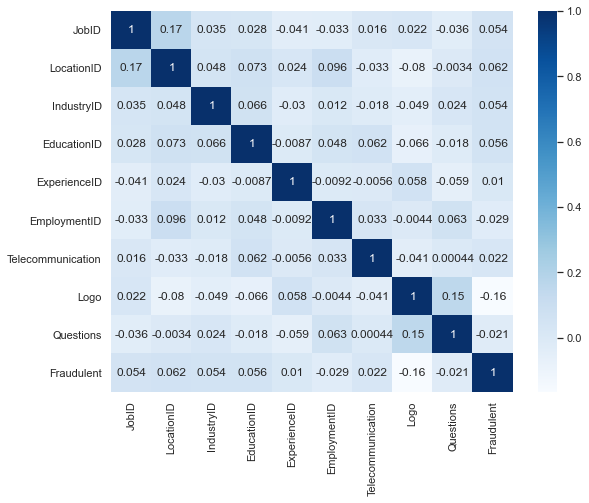

In [36]:
corr = master_table.corr()
fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(corr,cmap="Blues",ax=ax,annot=True)
plt.show()

In [37]:
len(master_table[master_table.Fraudulent == 0]), len(master_table[master_table.Fraudulent == 1]), 

(7699, 353)

<AxesSubplot:xlabel='Fraudulent', ylabel='count'>

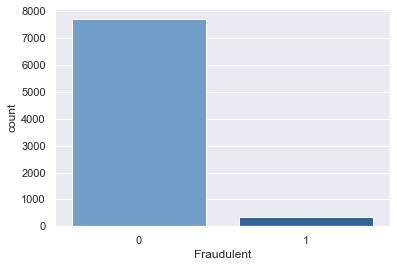

In [38]:
sns.countplot(x='Fraudulent', data=master_table,palette=['#619fd8',"#2162a9"])

In [39]:
df = master_table.merge(us_table, how='inner', on="LocationID")
df['State_City'] = df['State'] + ", " + df['City']
df1 = df.merge(employmenttype_table, how='inner', on="EmploymentID")
df1 = df1.merge(experiencetype_table, how='inner', on="ExperienceID")
df1 = df1.merge(educationtype_table, how='inner', on="EducationID")
df1 = df1.merge(industrytype_table, how='inner', on="IndustryID")


In [40]:
df1

,JobID,JobType,LocationID,IndustryID,EducationID,ExperienceID,EmploymentID,Company_Profile,Company_Description,Requirement,...,Questions,Fraudulent,Country,State,City,State_City,Employment,Experience,Education,Industry
0,1,Account Executive - Washington DC,3,2,1,3,2,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",...,0,0,US,DC,Washington,"DC, Washington",Full-time,Mid-Senior level,Bachelor's Degree,Computer Software
1,3310,Senior Test Engineer,3,2,1,3,2,EUROPEAN DYNAMICS (#URL_c66532ffa1ce76ab447da6...,800x600 Normal 0 false false ...,"Your skills:University degree, with minimum 6 ...",...,0,0,US,DC,Washington,"DC, Washington",Full-time,Mid-Senior level,Bachelor's Degree,Computer Software
2,3740,GIS Analyst-Programmer (ArcGIS),3,2,1,3,2,EUROPEAN DYNAMICS (#URL_c66532ffa1ce76ab447da6...,We currently have a vacancy for a GIS Analyst ...,Your skills:Minimum 13 years of combined Unive...,...,0,0,US,DC,Washington,"DC, Washington",Full-time,Mid-Senior level,Bachelor's Degree,Computer Software
3,3847,Field Engineer,3,2,1,3,2,Graphs are everywhere. From websites adding so...,(graphs) -[:ARE]-&gt; (everywhere)We want you ...,"To be successful, you’ll want to have experien...",...,0,0,US,DC,Washington,"DC, Washington",Full-time,Mid-Senior level,Bachelor's Degree,Computer Software
4,4221,Senior Test Engineer,3,2,1,3,2,EUROPEAN DYNAMICS (#URL_c66532ffa1ce76ab447da6...,We currently have a vacancy for a Senior Test ...,Your skills:University Degree in IT with minim...,...,0,0,US,DC,Washington,"DC, Washington",Full-time,Mid-Senior level,Bachelor's Degree,Computer Software
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8047,7390,web project manager,54,130,6,5,3,Ryanair is Europe’s favourite low fares airlin...,Ryanair is Europe’s favourite low fares airlin...,Management of all Outsourcing daily operations...,...,0,0,US,FL,Jacksonville,"FL, Jacksonville",Part-time,Entry level,Vocational,Alternative Dispute Resolution
8048,4970,PT Environmental Educator,58,125,5,5,3,Envision Consulting conducts retained searches...,Organization: The Children's Nature Institute'...,"- AA or BA in Science, Education or related fi...",...,0,0,US,CA,Los Angeles,"CA, Los Angeles",Part-time,Entry level,Some College Coursework Completed,Museums and Institutions
8049,2600,Ballet Teacher,52,121,9,4,3,,Ballet Teacher required for Herts area at a we...,Fully trained Ballet teacher with crb checking...,...,0,0,US,NC,Raleigh,"NC, Raleigh",Part-time,Associate,Professional,Performing Arts
8050,6477,Senior Thin Film Designer,5,124,10,3,2,Metamaterial Technologies Inc. (MTI) is a Cana...,MTI is looking for exceptional scientists and ...,"You’ll need to be smart, committed and practic...",...,0,0,US,CA,San Francisco,"CA, San Francisco",Full-time,Mid-Senior level,Doctorate,Nanotechnology


In [41]:
def sns_countplot(feature):
    sns.countplot(x=feature, data=df1, hue="Fraudulent",
              order=df1[feature].value_counts().iloc[:10].index)
    plt.xticks(rotation=90)
    title = feature + ' Fake Job Count'
    plt.title('Location Fake Jobs')
    plt.show()

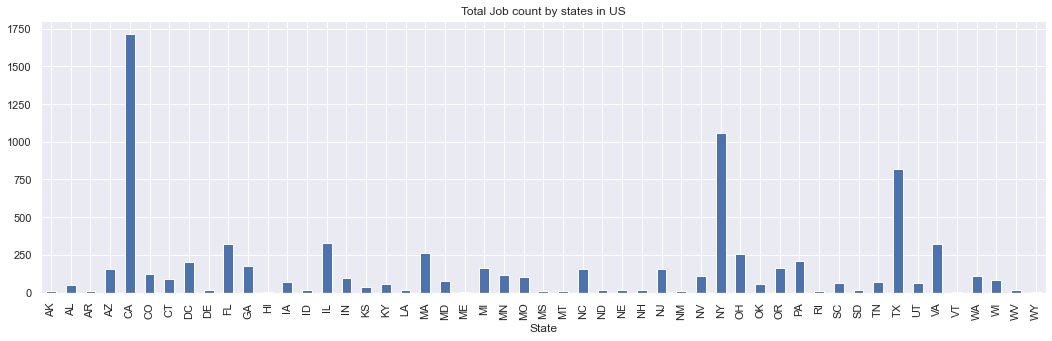

In [42]:
plt.figure(figsize=(18,5)).add_gridspec(2, 1, height_ratios=[5, 8])
df.groupby('State').Fraudulent.count().plot(kind='bar', title='Total Job count by states in US');

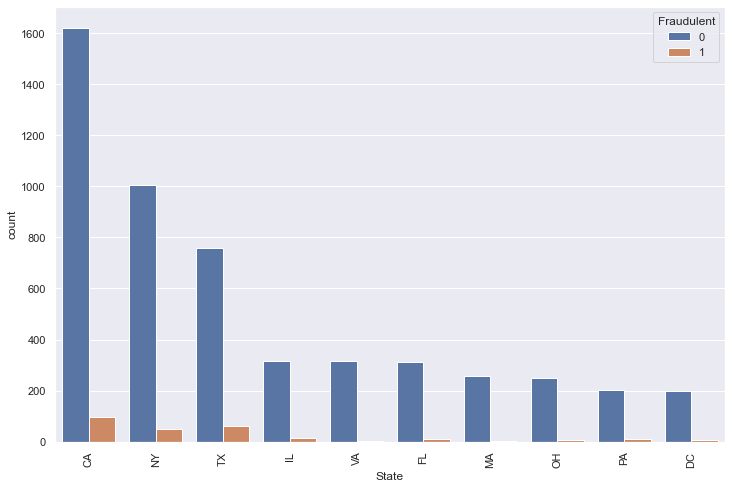

In [43]:
plt.figure(figsize=(12,8))
sns.countplot(x='State', data=df, hue="Fraudulent", order=df['State'].value_counts().iloc[:10].index)
plt.xticks(rotation=90)
plt.show()

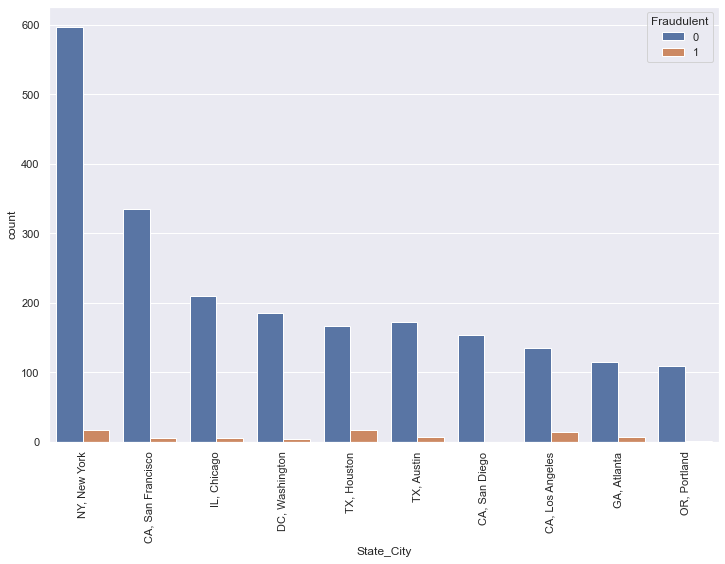

In [44]:
plt.figure(figsize=(12,8))
sns.countplot(x='State_City', data=df, hue="Fraudulent", order=df['State_City'].value_counts().iloc[:10].index)
plt.xticks(rotation=90)
plt.show()

In [45]:
def sns_countplot(feature):
    plt.figure(figsize=(10,6))
    sns.countplot(x=feature, data=df1, hue="Fraudulent",
              order=df1[feature].value_counts().iloc[:10].index)
    plt.xticks(rotation=90)
    title = feature + ' Fake Job Count'
    plt.title(title)
    plt.show()

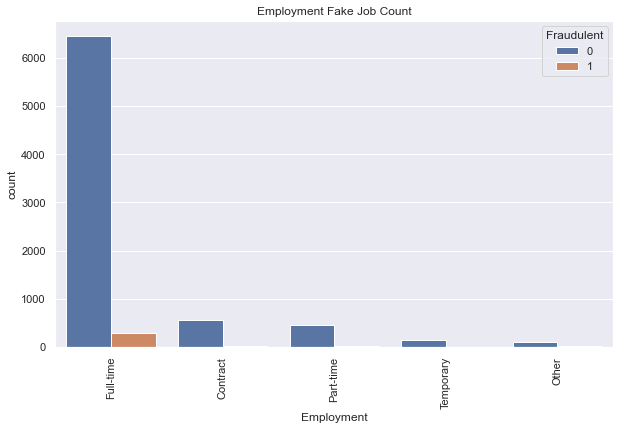

In [46]:
sns_countplot('Employment');

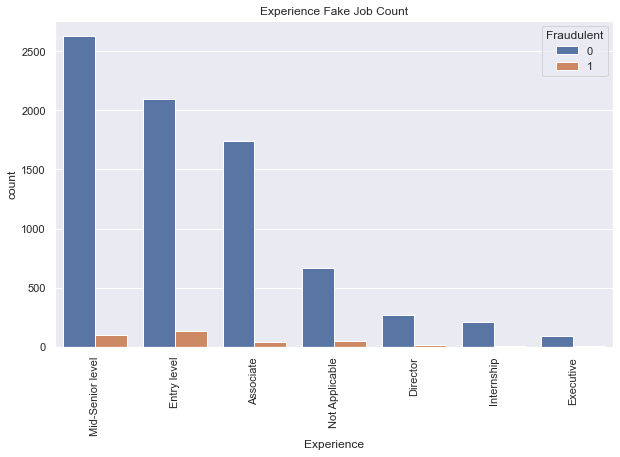

In [47]:
sns_countplot('Experience');

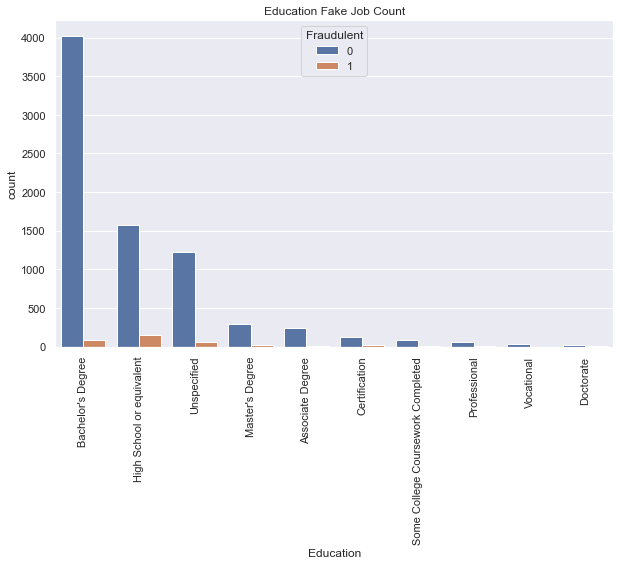

In [48]:
sns_countplot('Education');

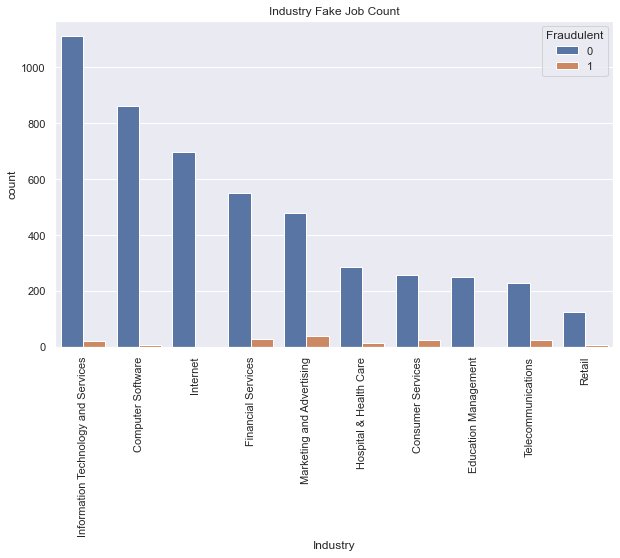

In [49]:
sns_countplot('Industry');

In [50]:
location_ratio = round(df1[df1.Fraudulent == 1].groupby('State_City').State_City.count()/df1[df1.Fraudulent == 0].groupby('State_City').State_City.count(), 2)
location_ratio = pd.DataFrame({'State_City':location_ratio.index, 'ratio':location_ratio.values})

In [51]:
df1 = df1.merge(location_ratio)

In [52]:
df1.ratio.fillna(0, inplace=True)

In [53]:
location_ratio_plot = location_ratio[location_ratio.ratio >= 1]

In [54]:
# location_ratio_plot

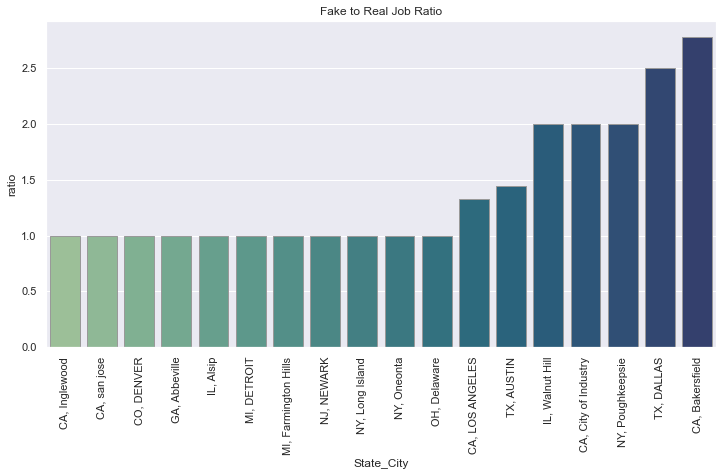

In [55]:
plt.figure(figsize=(12,6))
sns.barplot(data=location_ratio_plot.sort_values(by='ratio'), x='State_City', y='ratio',palette="crest",linewidth=1,edgecolor=".6")
plt.xticks(rotation=90)
plt.title('Fake to Real Job Ratio')
plt.show()

In [56]:
def missing_count(feature, title='None'):
    y_axis = fake_job_postings_US[fake_job_postings_US[feature].isna()][['fraudulent', feature]]
    y_axis = y_axis.fraudulent.value_counts()
    y_axis.plot(kind='bar')
    plt.ylabel('Count')
    plt.xlabel('Category')
    title = "Number of empty " + title + " in Fraudulent and Non-Fraudulent"
    plt.title(title)
    plt.xticks(rotation=0)
    plt.show()

#0- Non-Fraudulent 
#1- Fraudulent

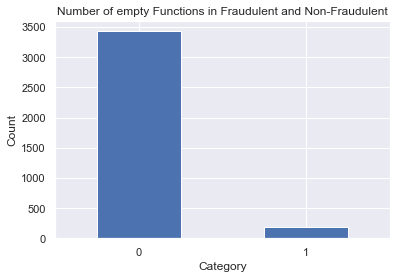

In [57]:
missing_count('function', 'Functions')

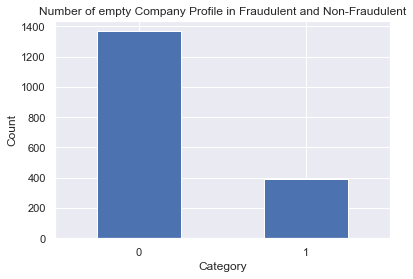

In [58]:
missing_count('company_profile', 'Company Profile')

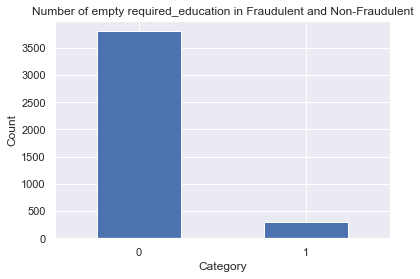

In [59]:
missing_count('required_education', 'required_education')

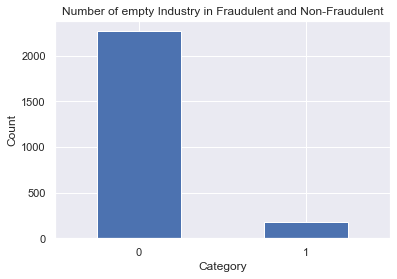

In [60]:
missing_count('industry', 'Industry')

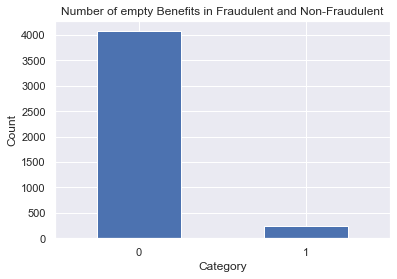

In [61]:
missing_count('benefits', 'Benefits')

In [62]:
telecommuting_list = []
has_company_logo_list = []

for idx, tel, logo in zip(range(len(df1)), df1.Telecommunication, df1.Logo):
    if df1.Fraudulent[idx] == 1:
        telecommuting_list.append(tel)
        has_company_logo_list.append(logo)
    else:
        pass

telecommuting_logo_df = pd.DataFrame({'Telecommunication':telecommuting_list, 'Logo':has_company_logo_list})

In [63]:
telecommuting_logo_df

,Telecommunication,Logo
0,0,1
1,0,0
2,0,0
3,0,0
4,1,1
...,...,...
348,0,1
349,0,1
350,0,1
351,0,1


In [64]:
fake_count = 0

for fraud, tel, logo in zip(df1.Fraudulent, df1.Telecommunication, df1.Logo):
    if (tel == 0 and logo == 0):
        if (fraud == 1):
            fake_count +=1
        else:
            pass
    else:
        pass

print(fake_count)

137


In [65]:
fake_count = 0

for fraud, tel, logo, ques in zip(df1.Fraudulent, df1.Telecommunication, df1.Logo, df1.Questions):
    if (tel == 0):
        if (fraud == 1):
            fake_count +=1
        else:
            pass
    else:
        pass

print(fake_count)

326


In [66]:
len(df1[df1.Fraudulent == 1])

353

In [67]:
326/353

0.9235127478753541

In [68]:
fake_count/len(df1[df1.Fraudulent == 1]) * 100

92.3512747875354

In [73]:
df_FakeJob = pd.DataFrame(columns = ['Telecommunication','Fraudulent','Text'])

df_FakeJob['Text'] =  df1['JobType'] + ' ' + df1['Country']+ ' ' + df1['State']+ ' ' + df1['City'] + ' ' + df1['Company_Profile'] + ' ' + \
        df1['Company_Description'] + ' ' + df1['Requirement'] + ' ' + df1['Benefits'] + ' ' + \
        df1['Experience'] + ' ' + df1['Education'] + ' ' + df1['Industry']

df_FakeJob['Telecommunication']=df1['Telecommunication']
df_FakeJob['Fraudulent']=df1['Fraudulent']


In [74]:
df_FakeJob

,Telecommunication,Fraudulent,Text
0,0,0,Account Executive - Washington DC US DC Washin...
1,0,0,Senior Test Engineer US DC Washington EUROPEAN...
2,0,0,GIS Analyst-Programmer (ArcGIS) US DC Washingt...
3,1,0,Field Engineer US DC Washington Graphs are eve...
4,0,0,Senior Test Engineer US DC Washington EUROPEA...
...,...,...,...
8047,0,0,Truck Driver - CDL Truck Driver - Truck Drivin...
8048,0,0,Van Foreman / Driver - Class A US IL Champaign...
8049,0,1,Clerical Assistant US NY ALBANY The Clerical ...
8050,0,0,Production Manager US AZ Buckeye Production M...


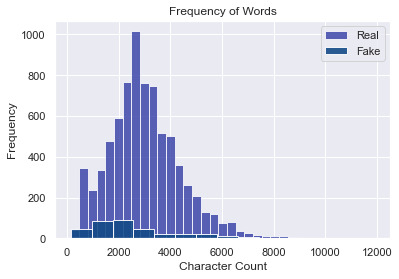

In [76]:
df_FakeJob['character_count'] = df_FakeJob.Text.apply(len)

df_FakeJob[df_FakeJob.Fraudulent==0].character_count.plot(bins=35, kind='hist', color='#313ca5', 
                                       label='Real', alpha=0.8)
df_FakeJob[df_FakeJob.Fraudulent==1].character_count.plot(kind='hist', color='#144a87', 
                                       label='Fake', alpha=0.9)
plt.legend()

plt.title('Frequency of Words')
plt.xlabel("Character Count");

In [77]:
df_FakeJob

,Telecommunication,Fraudulent,Text,character_count
0,0,0,Account Executive - Washington DC US DC Washin...,5532
1,0,0,Senior Test Engineer US DC Washington EUROPEAN...,4574
2,0,0,GIS Analyst-Programmer (ArcGIS) US DC Washingt...,3096
3,1,0,Field Engineer US DC Washington Graphs are eve...,2780
4,0,0,Senior Test Engineer US DC Washington EUROPEA...,3688
...,...,...,...,...
8047,0,0,Truck Driver - CDL Truck Driver - Truck Drivin...,1767
8048,0,0,Van Foreman / Driver - Class A US IL Champaign...,2013
8049,0,1,Clerical Assistant US NY ALBANY The Clerical ...,873
8050,0,0,Production Manager US AZ Buckeye Production M...,699
